# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

Next, we install minimal required dependencies.

## Loading the model

We load and print the config.

In [144]:
import argparse, os, sys, datetime, glob, importlib
from omegaconf import OmegaConf
import numpy as np
from PIL import Image
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn.functional as F
from dataset import dataset_combine, dataset_unpair, dataset_single
from torch.utils.data import DataLoader
import os

from taming_comb.modules.style_encoder.network import *
from taming_comb.modules.diffusionmodules.model import * 

from taming_comb.models.cond_transformer import * 

import argparse

def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)



def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))

os.environ["CUDA_VISIBLE_DEVICES"]='1'


device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print('device: ', device)
batch_size = 1 # 128
learning_rate = 1e-5       # 256/512 lr=4.5e-6 from 71 epochs
ne = 512  # Enlarge
ed = 512
img_size = 256

switch_weight = 0.1 # self-reconstruction : a2b/b2a = 10 : 1

dataset = 'summer2winter'

first_model_save_path = '{}_{}_{}_settingc_{}'.format(dataset, ed, ne, img_size)    # first stage model dir
save_path = dataset + '{}_{}_{}_transformer'.format(dataset, ed, ne)    # second stage model dir
print(save_path)
root = '/home/jenny870207/data/' + dataset + '/'

# load data
train_data = dataset_unpair(root, 'train', img_size, img_size)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)

# load first stage model
'''f = os.path.join(os.getcwd(), first_model_save_path, 'settingc_latest.pt')
config = OmegaConf.load('config_comb.yaml')
config.model.params.embed_dim = args.ed
config.model.params.n_embed = args.ne
config.model.z_channels = args.z_channel
config.model.resolution = 256
first_model = instantiate_from_config(config.model)
if(os.path.isfile(f)):
    print('load ' + f)
    ck = torch.load(f, map_location=device)
    first_model.load_state_dict(ck['model_state_dict'], strict=False)
first_model = first_model.to(device)
first_model.eval()'''

# load second stage model
f = os.path.join(os.getcwd(), save_path, 'latest.pt')

transformer_config = OmegaConf.load('transformer.yaml')
transformer_config.model.params.first_stage_model_config.params.embed_dim = ed
transformer_config.model.params.first_stage_model_config.params.n_embed = ne
transformer_config.model.params.first_stage_model_config.z_channels = 256
transformer_config.model.params.first_stage_model_config.resolution = 256
transformer_config.model.params.f_path = os.path.join(os.getcwd(), first_model_save_path, 'settingc_latest.pt')
transformer_config.model.params.device = str(device)
model = instantiate_from_config(transformer_config.model)

if(os.path.isfile(f)):
    print('load ' + f)
    ck = torch.load(f, map_location=device)
    model.load_state_dict(ck['model_state_dict'], strict=False)
model = model.to(device)
model.eval()


device:  cuda
summer2wintersummer2winter_512_512_transformer
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
load /home/jenny870207/VQI2I-setting-c/summer2winter_512_512_settingc_256/settingc_latest.pt


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 31.75 GiB total capacity; 23.68 GiB already allocated; 2.75 MiB free; 24.74 GiB reserved in total by PyTorch)

Instantiate the model.

Load the checkpoint.

## Load example data

Load an example segmentation and visualize.

In [ ]:
from PIL import Image
import numpy as np
'''img_path = "/home/jenny870207/data/summer2winter/trainB/2005-06-26 14:04:52.jpg"
img = Image.open(img_path)
display(img)
img = np.array(img)
print(img.shape)
img = np.eye(256)[img]
img = torch.tensor(img.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)'''

root = '/home/jenny870207/data/{}'.format(dataset)
validation_data = dataset_single(root, 'train', 'A', img_size, img_size, flip=False)
test_loader = DataLoader(validation_data, batch_size=1, shuffle=True, pin_memory=True)
img = next(iter(test_loader))
img = img.to(device)
print(img.shape)

torch.Size([1, 3, 256, 256])


Visualize

Our model also employs a VQGAN for the conditioning information, i.e. the segmentation in this example. Let's autoencode the segmentation map. Encoding returns both the quantized code and its representation in terms of indices of a learned codebook.

Let's sample indices corresponding to codes from the image VQGAN given the segmentation code. We init randomly and take a look.

In [ ]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

'''codebook_size = config.model.params.first_stage_model_config.params.embed_dim
#z_indices_shape = #c_indices.shape
#z_code_shape = #c_code.shape
z_indices = torch.randint(codebook_size, 16*16, device=model.device)
x_sample = model.decode_to_img(z_indices, z_code_shape)
show_image(x_sample)'''

'codebook_size = config.model.params.first_stage_model_config.params.embed_dim\n#z_indices_shape = #c_indices.shape\n#z_code_shape = #c_code.shape\nz_indices = torch.randint(codebook_size, 16*16, device=model.device)\nx_sample = model.decode_to_img(z_indices, z_code_shape)\nshow_image(x_sample)'

## Sample an image

We use the transformer in a sliding window manner to sample all code entries sequentially. The code below assumes a window size of $16\times 16$.

In [ ]:
import matplotlib.pyplot as plt
def tensor2im(input_image, imtype=np.uint8):
    """"Converts a Tensor array into a numpy image array.

    Parameters:
        input_image (tensor) --  the input image tensor array
        imtype (type)        --  the desired type of the converted numpy array
    """
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):  # get the data from a variable
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor[0].clamp(-1.0, 1.0).cpu().float().numpy()  # convert it into a numpy array
        if image_numpy.shape[0] == 1:  # grayscale to RGB
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0  # post-processing: tranpose and scaling
    else:  # if it is a numpy array, do nothing
        image_numpy = input_image
    return image_numpy.astype(imtype)





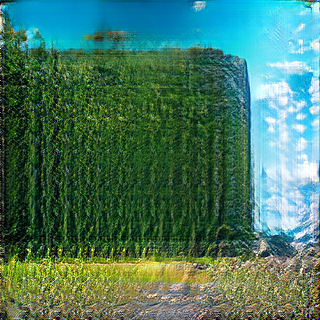

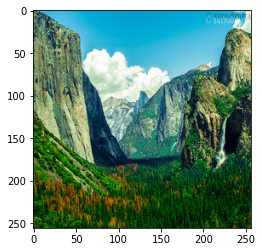

In [ ]:
from IPython.display import clear_output
import time


original_size = 16
size = 20

window_size = 6
#int(window_size/2)

z_code, z_indices, style = model.encode_to_z(img, 1)
z_code_shape = z_code.shape
#print('z_code_shape: ', z_code_shape)
z_indices_shape = z_indices.shape
#print(z_code.shape)

style = model.first_stage_model.encode_style(img, 1)

codebook_size = 512

z_random = torch.randint(codebook_size, (size*size,)).to(device)
z_random = z_random.reshape(z_code_shape[0], size, size)
z_random[:, :original_size, :original_size] = z_indices.reshape(z_code_shape[0], original_size, original_size)

idx = z_random
#idx = z_indices
idx = idx.reshape(z_code_shape[0],size,size)


coordinate = np.arange(size*size).reshape(size,size,1)/(size*size)
coordinate = torch.from_numpy(coordinate)
c = model.get_c(coordinate)
c = torch.squeeze(c, 1)
cidx = c.to(device)
cidx = cidx.to(dtype=torch.long)

temperature = 1.0
top_k = None#100
update_every = 50

start_t = time.time()
for i in range(0, z_code_shape[2]-0):
  if i <= int(window_size/2):
    local_i = i
  elif z_code_shape[2]-i < int(window_size/2):
    local_i = window_size-(z_code_shape[2]-i)
  else:
    local_i = int(window_size/2)
  for j in range(0,z_code_shape[3]-0):
    if j <= int(window_size/2):
      local_j = j
    elif z_code_shape[3]-j < int(window_size/2):
      local_j = window_size-(z_code_shape[3]-j)
    else:
      local_j = int(window_size/2)

    i_start = i-local_i
    i_end = i_start + window_size
    j_start = j-local_j
    j_end = j_start + window_size
    
    patch = idx[:,i_start:i_end,j_start:j_end]
    patch = patch.reshape(patch.shape[0],-1)
    cpatch = cidx[:, i_start:i_end, j_start:j_end]
    cpatch = cpatch.reshape(cpatch.shape[0], -1)

    patch = torch.cat((cpatch, patch), dim=1)
    logits,_ = model.transformer(patch[:,:-1]) #[:,:-1]
  

    #print(logits.shape)
    logits = logits[:, -window_size*window_size:, :]
    logits = logits.reshape(z_code_shape[0],window_size,window_size,-1)
    #print(logits.shape)
    logits = logits[:,local_i,local_j,:]
    #print(logits.shape)

    logits = logits/temperature

    if top_k is not None:
      logits = model.top_k_logits(logits, top_k)

    probs = torch.nn.functional.softmax(logits, dim=-1)
    idx[:,i,j] = torch.multinomial(probs, num_samples=1)
 
  
    '''step = i*z_code_shape[3]+j
    if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:


      x_sample = model.decode_to_img(idx, z_code_shape, style, 0)
      #clear_output()
      print(f"Time: {time.time() - start_t} seconds")
      print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")

      show_image(x_sample)'''

x_sample = model.decode_to_img(idx, (1, codebook_size, size, size), style, 1)
show_image(x_sample)
plt.imshow(tensor2im(img))
